# Determine whether within-host variants detected in Wisconsin transmission pairs are present on the SARS-CoV2 phylogeny

May 8, 2020

Kat and Gage have sequenced SARS-CoV2 from putative transmission pairs in Wisconsin. In this data, they see that there is a lot of shared within-host diversity between pairs, but that a lot of this diversity is also shared among non-transmission pairs of samples. This is concerning and a little weird. This was also observed in [this paper](https://www.medrxiv.org/content/10.1101/2020.04.24.20078691v1) that Gage found, although I have not read it closely. 

There are a few questions that I think would be nice to try to address by looking at the phylogeny: 

1. Are any of these recurrent within-host mutations also ones identified as problematic/likely errors by people looking at consensus data? If so, these should probably be excluded. I will use this virological post [here](http://virological.org/t/issues-with-sars-cov-2-sequencing-data/473)

2. How frequently do within-host variants appear in consensus sequences? I would hypothesize that the vast majority of within-host variation being generated is not particularly advantageous. In this scenario, we would expect to observe only a small fraction of these within-host variants on the phylogeny, and when we do, we expect them to be primarily observed at terminal nodes rather than on internal branches.

3. Do any of these within-host variants appear downstream at the consensus level from the host they were sampled in? By this I mean, if we observe a within-host variant in a particular person, is that infection upstream of later sampled cases? If so, is that variant detected at consensus level in any of those offspring infections? We will see. 


I think that for this analysis, it may be worthwhile to try to help them set up a Wisconsin-focused community build. This could use the new snakemake rules to generate a community build that focuses on Wisconsin but also pulls in sequences from elsewhere. This might be a nice thing to help facilitate and it would absolutely provide them with a better tree for inference than their current Wisconsin-only build. 

Kat mapped the genomes to this reference: MN908947.3.

This is a link to their local nextstrain build http://35.226.31.45/Wisconsin?branchLabel=aa&c=clade_membership&r=location

One note here is that indels are labelled differently in Kat's output files than in the nextstrain tree. In the nextstrain tree, `-505A` means that there was an A insertion at 505. `A505-` means that there was a deletion at 505. 

### Requirements: 
To run this, you will need to have all of the modules in the following block installed. You will also need to have the most recent version of baltic installed, which is available [here](https://github.com/evogytis/baltic/tree/master/docs).

In [1]:
import imp
import importlib, json
import glob
import re,copy,json
import Bio.Phylo
import requests
import pandas as pd 
import numpy as np

# for this to work, you will need to download the most recent version of baltic, available here 
bt = imp.load_source('baltic', '../baltic/baltic.py')

import copy
from scipy.special import binom
import datetime as dt

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
import textwrap as textwrap
from textwrap import wrap

from IPython.display import HTML


try:
    from StringIO import StringIO as sio
    from cStringIO import StringIO as csio
except ImportError:
    from io import StringIO as sio
    from io import BytesIO as csio
    
    
import rpy2
%load_ext rpy2.ipython

In [2]:
# define which column we want to use to look at variants. Use 'nuc_muts' to characterize variants relative to the 
# Wuhan 1 reference, or 'minor_nuc_muts' to do a consensus-agnostic comparison
variant_column = 'minor_nuc_muts'
frequency_column = 'minor_frequency'

## Read in vcfs and convert to dataframes 

I will only read in the intersection SNVs, meaning the ones that were detected in both technical sequencing replicates. This code will separate this into 2 dataframes, 1 for SNVs and 1 for indels, and will also look up and add in the strain names (necessary for converting from tube numbers, which is how the csvs are labelled). All of this code is contained in the ipython notebook called `vcf-module.ipynb`, which I am just going to import here. By running `return_dataframes`, this will collate all vcfs in the vcf directory, combine into a dataframe, and format that dataframe properly. 

In [3]:
"""to load in an ipython notebook as a module, just run the following. You will now have access to all of the 
functions written in that jupyter notebook"""

%run vcf-module.ipynb

In [4]:
# read in the current date 
from datetime import date
today = date.today()
current_date = str(today.strftime("%Y-%m-%d"))

In [5]:
"""now, input the strain names file/metadata file, the directory containing the vcfs, and return the dataframess"""

strain_names_file = "/Users/lmoncla/src/ncov-WI-within-host/data/sample-metadata.tsv"
fasta_file = "../data/consensus-sequences-2021-01-25.fasta"
clades_file = "../data/clades-file-2020-08-28.txt"
vcf_directory = "../data/vcfs-all/"

# N transcript was a control; sample/tube 6, UW-30, has an snv at basically every single site after a certain 
# point in the genome. it has 418 SNVs!!! I'm excluding it; finally, I am going to exclude tube 127, USA/WI-UW-118/2020
# which has >50 indels and >50 SNVs. It has a pretty high Ct as well, so I think these are probably errors as it is 
# a very clear outlier
# remove 302, 303, 304, 302, 735, and 736 because these are time-series! 
samples_to_ignore = ["N_transcript","127","302","303","304","735","736"]

# set the length of homopolymers that you want to use
homopolymer_length = 3

# set the variant percent that you want to use 
variant_percent = "0.03"

snvs_only, all_intersection_variants,metadata_dict, strain_names_dict = return_dataframes(strain_names_file, clades_file,vcf_directory,samples_to_ignore,fasta_file, homopolymer_length)

In [6]:
"""gather twist sites"""
twist_sites = snvs_only[snvs_only['sampleid'] == "twist_rna"]['POS_x'].tolist()

"""remove all rows containing variants at twist sites"""
snvs_only = snvs_only[~snvs_only['POS_x'].isin(twist_sites)]

In [7]:
"""subset data to include only SNVs and indels >3% frequency"""
snvs_only = snvs_only[snvs_only[frequency_column] >= float(variant_percent)]

"""subset data to include only SNVs and indels <50% frequency"""
snvs_only = snvs_only[snvs_only[frequency_column] <= float(0.5)]

In [8]:
all_intersection_variants.head()

,Unnamed: 0,SNP,POS_x,rep1_percent,rep2_percent,frequency,sampleid,gene,nt_change,aa_change,annotation,strain_name,location,clade,homopolymer,homopolymer_base,type_of_variant
0,0,orf1ab_C>T_Ser2839Ser_synonymous,8782.0,0.9376,0.8802,0.90890,53,orf1ab,C>T,Ser2839Ser,synonymous,USA/WI-UW-67/2020,Dane County,19B,not,[],snv
1,1,orf1ab_G>A_Val5373Ile_missense,16381.0,0.9064,0.9449,0.92565,53,orf1ab,G>A,Val5373Ile,missense,USA/WI-UW-67/2020,Dane County,19B,not,[],snv
2,2,orf1ab_T>C_Thr5871Thr_synonymous,17877.0,0.9543,0.9387,0.94650,53,orf1ab,T>C,Thr5871Thr,synonymous,USA/WI-UW-67/2020,Dane County,19B,not,[],snv
3,3,orf1ab_C>T_Phe6684Phe_synonymous,20316.0,0.9047,0.9040,0.90435,53,orf1ab,C>T,Phe6684Phe,synonymous,USA/WI-UW-67/2020,Dane County,19B,not,[],snv
4,4,ORF3a_G>T_Pro36Pro_synonymous,25500.0,0.9523,0.9624,0.95735,53,ORF3a,G>T,Pro36Pro,synonymous,USA/WI-UW-67/2020,Dane County,19B,not,[],snv


In [9]:
print(len(all_intersection_variants))

1173


In [10]:
snvs_to_query = set(snvs_only[variant_column])
print(len(snvs_to_query))

185


## A small function to order the SNVs by site

In [11]:
"""given a list of SNVs, sort them by their site number to make the resuling plot easier to read and look at"""

def sort_mutations(muts):
    muts_dict = {}
    sites_list = []
    final_order = []
    
    for m in muts:
        site = int(m[1:-1])
        
        if site not in muts_dict:
            muts_dict[site] = []
            
        muts_dict[site].append(m)
        sites_list.append(site)
    
    sites_list = list(set(sites_list))
    sites_list.sort()
    
    for s in sites_list:
        for x in muts_dict[s]:
            final_order.append(x)
    
    return(final_order)

## Functions for parsing tree from nextstrain

The idea here will be to answer the following questions: 
1. What proportion of within-host variants are present on the tree? 
2. Do within-host variants have a skew towards being on internal vs. terminal branches, relative to the rest of the tree? If within-host variants are mostly deleterious, we would hypothesize that they should occur on the tree rarely and should be localized primarily to internal nodes. 
3. Are variants that are detected within-host in a given sample ever detected at consensus downstream of that sample? If the bottleneck is small and random, then I would not really expect to see this. If however, the bottleneck is really wide, then we might expect to observe this more often. The results here will need to be intergrated with Kat's actual estimates. 

In [12]:
def generate_snvs_dict_for_tree(query_list):
    snvs_on_tree = {}
    for q in query_list: 
        snvs_on_tree[q] = {"branches_with_snv":[], "arose_on_tip":0, "arose_on_internal_node":0}
    
    return(snvs_on_tree)

In [13]:
def enumerate_mutations_on_branches(tree, snvs_on_tree):    
    for k in tree.Objects:
        if 'branch_attrs' in k.traits:
            if 'mutations' in k.traits['branch_attrs']:
                if 'nuc' in k.traits['branch_attrs']['mutations']:
                    nt_muts = k.traits['branch_attrs']['mutations']['nuc']
                    for n in nt_muts: 
                        if n in snvs_on_tree:
                            snvs_on_tree[n]["branches_with_snv"].append(k.name)
                            
                            if k.branchType == "node":
                                leaves = 0 #len(k.leaves)
                                nodes = 1
                            elif k.branchType == "leaf":
                                leaves = 1
                                nodes = 0
                            
                            snvs_on_tree[n]["arose_on_tip"] += leaves
                            snvs_on_tree[n]["arose_on_internal_node"] += nodes
                            
    return(snvs_on_tree)

In [14]:
def enumerate_all_tree_muts(tree):
    
    all_snps_on_tree = {}
    total_snps = {"internal_nodes": 0, "tips":0}
    
    for k in tree.Objects:
        if 'branch_attrs' in k.traits:
            if 'mutations' in k.traits['branch_attrs']:
                if 'nuc' in k.traits['branch_attrs']['mutations']:
                    nt_muts = k.traits['branch_attrs']['mutations']['nuc']
                    for n in nt_muts:
                        if n not in all_snps_on_tree: 
                            all_snps_on_tree[n] = {"branches_with_snv":[], "arose_on_tip":0, "arose_on_internal_node":0}
                        
                        all_snps_on_tree[n]["branches_with_snv"].append(k.name)

                        if k.branchType == "node":
                            leaves = 0 #len(k.leaves)
                            nodes = 1
                        elif k.branchType == "leaf":
                            leaves = 1
                            nodes = 0

                        all_snps_on_tree[n]["arose_on_tip"] += leaves
                        all_snps_on_tree[n]["arose_on_internal_node"] += nodes
                            
                    
                    if k.branchType == "node":
                        total_snps["internal_nodes"] += len(nt_muts)
                    elif k.branchType == "leaf":
                        total_snps['tips'] += len(nt_muts)
                        
    return(all_snps_on_tree, total_snps)

## Grab the most recent json file from nextstrain, and read it in as a baltic tree object 

The current `json_translation` defined here will translate auspice v2 jsons attributes into the proper tree attributes. This will not work for auspice v1 jsons. All ncov jsons are in v2. 

In [15]:
# most recent global ncov json
json_url='http://data.nextstrain.org/ncov_global.json'
tree_json=json.load(csio(requests.get(json_url).content))

# or, instead we can use the wisconsin nextstrain build which incorporates global context. That might make more sense
#tree_path = "/Users/lmoncla/src/ncov-WI-within-host/data/ncov_wisconsin_statewide.json"
# with open(tree_path) as json_file:
#     tree_json = json.load(json_file)

analysis_level = "division"

tree_object=tree_json['tree']
meta=tree_json['meta']
json_translation={'absoluteTime':lambda k: k.traits['node_attrs']['num_date']['value'],'name':'name'} ## allows baltic to find correct attributes in JSON, height and name are required at a minimum
#json_meta={'file':meta,'traitName':analysis_level} ## if you want auspice stylings you can import the meta file used on nextstrain.org

tree=bt.loadJSON(tree_object,json_translation)


Tree height: 1.146986
Tree length: 853.200612
multitype tree
annotations present

Numbers of objects in tree: 7295 (3356 nodes and 3939 leaves)



In [16]:
variants_to_query = snvs_to_query

In [17]:
snvs_on_tree_dict = generate_snvs_dict_for_tree(variants_to_query)
snvs_on_tree_dict = enumerate_mutations_on_branches(tree, snvs_on_tree_dict)
full_tree_muts,tree_mut_counts = enumerate_all_tree_muts(tree)

In [18]:
full_tree_df = pd.DataFrame.from_dict(full_tree_muts, orient="index")
full_tree_df.reset_index(inplace=True)
full_tree_df.columns = ['snv','branches_with_snv','arose_on_tip','arose_on_internal_node']
full_tree_df.head()

,snv,branches_with_snv,arose_on_tip,arose_on_internal_node
0,-11288T,"[NODE_0000693, NODE_0000724, SouthAfrica/KRISP...",11,3
1,-11289C,"[NODE_0000693, SouthAfrica/KRISP-K008203/2021,...",10,2
2,-11289G,"[NODE_0000724, Botswana/CV1404955/2021]",1,1
3,-11290T,"[NODE_0000693, NODE_0000727, SouthAfrica/KRISP...",11,3
4,-11291G,"[NODE_0000693, SouthAfrica/KRISP-K008203/2021,...",10,2


In [19]:
snps_on_tips = full_tree_df['arose_on_tip'].sum()
snps_on_nodes = full_tree_df['arose_on_internal_node'].sum()
print(tree_mut_counts)

{'internal_nodes': 4637, 'tips': 17200}


In [20]:
df = pd.DataFrame.from_dict(snvs_on_tree_dict, orient="index")
df.reset_index(inplace=True)
df.columns = ['snv','branches_with_snv','arose_on_tip','arose_on_internal_node']
df1 = df[['snv','arose_on_tip','arose_on_internal_node']]
df.head()

,snv,branches_with_snv,arose_on_tip,arose_on_internal_node
0,NaN,[],0,0
1,T8818C,[],0,0
2,A11983G,"[Finland/28A90S17/2020, NODE_0002540, NODE_000...",1,2
3,T12459C,[],0,0
4,G28919T,[],0,0


In [21]:
# print number/fraction of SNVs that are never on the tree 
not_on_tree = len(df[(df['arose_on_tip'] == 0) & (df['arose_on_internal_node'] == 0)])
print("SNVS not on tree:", not_on_tree)
print("SNVS on tree:", len(df) - not_on_tree)
print("total SNVS:", len(df))
print("the total fraction of within-host variants that are found on the tree is ", (len(df)-not_on_tree)/len(df))
print("the total fraction of within-host variants that are NOT found on the tree is ", not_on_tree/len(df))

SNVS not on tree: 108
SNVS on tree: 77
total SNVS: 185
the total fraction of within-host variants that are found on the tree is  0.41621621621621624
the total fraction of within-host variants that are NOT found on the tree is  0.5837837837837838


### Question 1: What fraction of variants are on the tree? 

SNVs: 30% are found on the tree, 70% are not

indels: 0% are found on the tree

overall: 20% of variants are found on the tree, 80% are not

In [22]:
# for all within-host variants added together, print the number of times they appear on tips and on internal nodes
within_host_on_tips = df['arose_on_tip'].sum()
within_host_on_nodes = df['arose_on_internal_node'].sum()
print(within_host_on_tips, within_host_on_nodes)

411 128


In [24]:
# do a Fisher's exact test, testing whether within-host variants have a different ratio of internal node to terminal
# node appearance than other mutations on the tree
import scipy
from scipy import stats
table = [[snps_on_nodes,snps_on_tips],[within_host_on_nodes,within_host_on_tips]]
odds_ratio,pvalue = stats.fisher_exact(table)

print(odds_ratio, pvalue)
print(table)

0.8656463481104651 0.1660572804496328
[[4637, 17200], [128, 411]]


In [25]:
# compare with Fishers exact test 
# now run on actual data
import scipy 
from scipy import stats

p_values = {}

for index, row in df.iterrows():
    mutation = row['snv']
    on_tips = row['arose_on_tip']
    on_internal_nodes = row['arose_on_internal_node']
    
    table = [[snps_on_nodes,snps_on_tips],[on_internal_nodes,on_tips]]
    odds_ratio, p_value = (stats.fisher_exact(table))
            
    if p_value < 0.05:
        print(mutation, p_value)
        print(table)
        
    # assign stars
    if p_value > 0.01 and p_value < 0.05:
        significance = "*"

    elif p_value > 0.001 and p_value < 0.01:
        significance = "**"
        
    elif p_value > 0.0001 and p_value < 0.001:
        significance = "***"
    
    elif p_value < 0.0001:
        significance = "****"
        
    else: 
        significance = ""
            
    p_values[mutation] = {"p_value":p_value, "significance":significance}

C27970T 0.03222856111158187
[[4637, 17200], [3, 1]]
C28887T 0.028495782535597935
[[4637, 17200], [10, 15]]


In [26]:
print(len(df[df['arose_on_tip'] == 0]))
print(len(df[df['arose_on_tip'] > 0]))
print(len(df))

108
77
185


In [27]:
print(len(df[df['arose_on_internal_node'] == 0]))
print(len(df[df['arose_on_internal_node'] > 0]))
print(len(df))

144
41
185


In [28]:
df.head()

,snv,branches_with_snv,arose_on_tip,arose_on_internal_node
0,NaN,[],0,0
1,T8818C,[],0,0
2,A11983G,"[Finland/28A90S17/2020, NODE_0002540, NODE_000...",1,2
3,T12459C,[],0,0
4,G28919T,[],0,0


In [29]:
df_to_plot = df.copy()
df_to_plot['total_counts'] = df_to_plot['arose_on_tip'] + df_to_plot['arose_on_internal_node']
df_to_plot = df_to_plot.melt(value_vars=['arose_on_tip','arose_on_internal_node'], id_vars=['snv','total_counts'])
df_to_plot.head()

,snv,total_counts,variable,value
0,NaN,0,arose_on_tip,0
1,T8818C,0,arose_on_tip,0
2,A11983G,3,arose_on_tip,1
3,T12459C,0,arose_on_tip,0
4,G28919T,0,arose_on_tip,0


In [30]:
# add in p-values column
p_values_df = pd.DataFrame.from_dict(p_values, orient="index")
p_values_df.reset_index(inplace=True)
p_values_df.columns = ["snv","p-value","significance"]


df_to_plot = df_to_plot.merge(p_values_df, on=['snv'])
df_to_plot.head()

,snv,total_counts,variable,value,p-value,significance
0,NaN,0,arose_on_tip,0,1.000000,
1,NaN,0,arose_on_internal_node,0,1.000000,
2,T8818C,0,arose_on_tip,0,1.000000,
3,T8818C,0,arose_on_internal_node,0,1.000000,
4,A11983G,3,arose_on_tip,1,0.116172,


In [31]:
print(len(df_to_plot))
df_to_plot.dropna(inplace=True)
print(len(df_to_plot))

370
368


In [32]:
df_to_plot = df_to_plot[~df_to_plot['snv'].str.contains("-")]
#df_to_plot = df_to_plot[df_to_plot['value'] > 0]
df_to_plot.head()

,snv,total_counts,variable,value,p-value,significance
2,T8818C,0,arose_on_tip,0,1.000000,
3,T8818C,0,arose_on_internal_node,0,1.000000,
4,A11983G,3,arose_on_tip,1,0.116172,
5,A11983G,3,arose_on_internal_node,2,0.116172,
6,T12459C,0,arose_on_tip,0,1.000000,


In [33]:
muts_to_sort = list(set(df_to_plot['snv'].tolist()))
order_of_variants = sort_mutations(muts_to_sort)

In [34]:
node_color = "#ECC58C"
tip_color = "#7C9BAC"
# original blue and red
# node_color = "#C75643"
# tip_color = "#545AB7"

In [35]:
# only plot variants that were found on the tree at least X times
times_detected_cutoff_to_plot = 10

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)


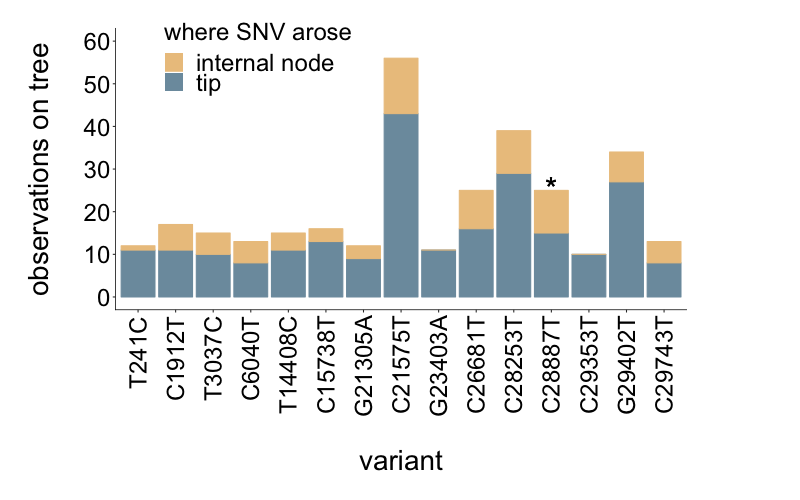

In [36]:
%%R -w 800 -h 500 -u px -i times_detected_cutoff_to_plot,order_of_variants,variant_percent,current_date,df_to_plot,tip_color,node_color  # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

df_to_plot <- df_to_plot[(df_to_plot$total_counts>=times_detected_cutoff_to_plot),]

output_filename = paste("SNVs-on-global-tree-",times_detected_cutoff_to_plot,"x-",variant_percent,"percent-",current_date,".pdf", sep="")
df_to_plot$snv_f = factor(df_to_plot$snv, levels=c(order_of_variants))

p <- ggplot(data=df_to_plot, aes(x=snv_f, y=value, color=variable, fill=variable)) + 
    geom_col()+
    geom_text(data=df_to_plot, aes(x=snv_f, y=total_counts + 0.5, label=significance), color="black",size=11)+
    labs(x="\nvariant",y="observations on tree\n")+
    scale_color_manual(values=c(arose_on_tip=tip_color,arose_on_internal_node=node_color), guide=FALSE)+
    scale_fill_manual(values=c(arose_on_tip=tip_color,arose_on_internal_node=node_color), labels=c(arose_on_tip="tip", arose_on_internal_node="internal node"))+
    scale_y_continuous(breaks=seq(0,60,10), limits=c(0,60))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=28, vjust=5))+
    theme(axis.text.y=element_text(size=24, colour="black"))+
    theme(axis.text.x=element_text(size=24, colour="black", angle=90, hjust=0.95, vjust=0.5))+
    theme(legend.text=element_text(size=24))+
    theme(legend.title=element_text(size=24))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    theme(legend.position = c(0.25, 0.9))+
    guides(fill=guide_legend(title="where SNV arose"))

ggsave(output_filename, width = 10, height = 7, device = "pdf", path = "../figures/individual-pdfs/", dpi = 300)
p

In [37]:
# only plot variants that were found on the tree at least X times
times_detected_cutoff_to_plot = 0

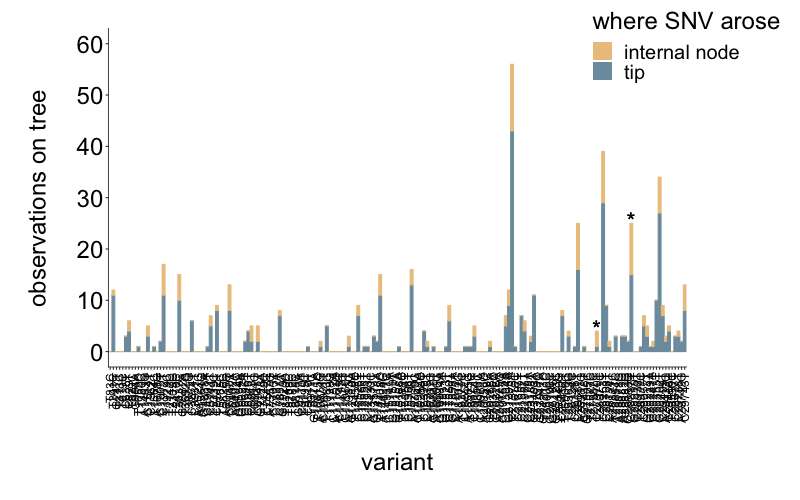

In [38]:
%%R -w 800 -h 500 -u px -i times_detected_cutoff_to_plot,order_of_variants,variant_percent,current_date,df_to_plot,tip_color,node_color  # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

df_to_plot <- df_to_plot[(df_to_plot$total_counts>=times_detected_cutoff_to_plot),]

output_filename = paste("SNVs-on-global-tree-all-",variant_percent,"percent-",current_date,".pdf", sep="")
df_to_plot$snv_f = factor(df_to_plot$snv, levels=c(order_of_variants))

p <- ggplot(data=df_to_plot, aes(x=snv_f, y=value, color=variable, fill=variable)) + 
    geom_col()+
    geom_text(data=df_to_plot, aes(x=snv_f, y=total_counts + 0.5, label=significance), color="black",size=8)+
    labs(x="\nvariant",y="observations on tree\n")+
    scale_color_manual(values=c(arose_on_tip=tip_color,arose_on_internal_node=node_color), guide=FALSE)+
    scale_fill_manual(values=c(arose_on_tip=tip_color,arose_on_internal_node=node_color), labels=c(arose_on_tip="tip", arose_on_internal_node="internal node"))+
    scale_y_continuous(breaks=seq(0,60,10), limits=c(0,60))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=24, colour="black"))+
    theme(axis.text.x=element_text(size=12, colour="black", angle=90, hjust=0.95, vjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_text(size=24))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    theme(legend.position = c(1.0, 0.95))+
    guides(fill=guide_legend(title="where SNV arose"))

ggsave(output_filename, width = 40, height = 8, device = "pdf", path = "../figures/individual-pdfs/", dpi = 300)
p

## Are SNVs detected multiple times within-host more likely to be detected on the tree? 

In [39]:
s = snvs_only['minor_nuc_muts'].value_counts().rename_axis('snv').reset_index(name='within_host_counts')
s.head()

,snv,within_host_counts
0,T3037C,21
1,G15168A,18
2,T241C,18
3,T20316C,15
4,G15150T,12


In [40]:
within_vs_tree = df.copy()
within_vs_tree['total_tree_counts'] = within_vs_tree['arose_on_tip'] + within_vs_tree['arose_on_internal_node']
within_vs_tree = within_vs_tree[['snv','arose_on_tip','arose_on_internal_node','total_tree_counts']]
within_vs_tree = within_vs_tree.merge(s, on=['snv']).drop_duplicates()
within_vs_tree.head()

,snv,arose_on_tip,arose_on_internal_node,total_tree_counts,within_host_counts
0,T8818C,0,0,0,1
1,A11983G,1,2,3,1
2,T12459C,0,0,0,1
3,G28919T,0,0,0,1
4,C29738T,3,1,4,1


In [41]:
def return_label(row):
    tree_counts = int(row['total_tree_counts'])
    wh_counts = int(row['within_host_counts'])
    snv = row['snv']
    
    if tree_counts >= 5 and wh_counts >= 5:
        label = snv
    #elif tree_counts >=20 or wh_counts >= 20:
        #label = snv
    else:
        label = ""
        
    return(label)

In [42]:
# add in a column for a label
within_vs_tree['label'] = within_vs_tree.apply(return_label, axis=1)
within_vs_tree.head()

,snv,arose_on_tip,arose_on_internal_node,total_tree_counts,within_host_counts,label
0,T8818C,0,0,0,1,
1,A11983G,1,2,3,1,
2,T12459C,0,0,0,1,
3,G28919T,0,0,0,1,
4,C29738T,3,1,4,1,


In [43]:
# plot the same plot as above, but now with only SNVs detected multiple times 
df_to_plot2 = within_vs_tree.copy()
df_to_plot2 = df_to_plot2.melt(value_vars=['arose_on_tip','arose_on_internal_node'], id_vars=['snv','total_tree_counts','within_host_counts','label'])
df_to_plot2 = df_to_plot2.merge(p_values_df, on=['snv'])
df_to_plot2.dropna(inplace=True)
df_to_plot2.head()

,snv,total_tree_counts,within_host_counts,label,variable,value,p-value,significance
0,T8818C,0,1,,arose_on_tip,0,1.000000,
1,T8818C,0,1,,arose_on_internal_node,0,1.000000,
2,A11983G,3,1,,arose_on_tip,1,0.116172,
3,A11983G,3,1,,arose_on_internal_node,2,0.116172,
4,T12459C,0,1,,arose_on_tip,0,1.000000,


In [44]:
muts_to_sort = list(set(df_to_plot2['snv'].tolist()))
order_of_variants = sort_mutations(muts_to_sort)

In [45]:
times_detected_cutoff_to_plot = 2

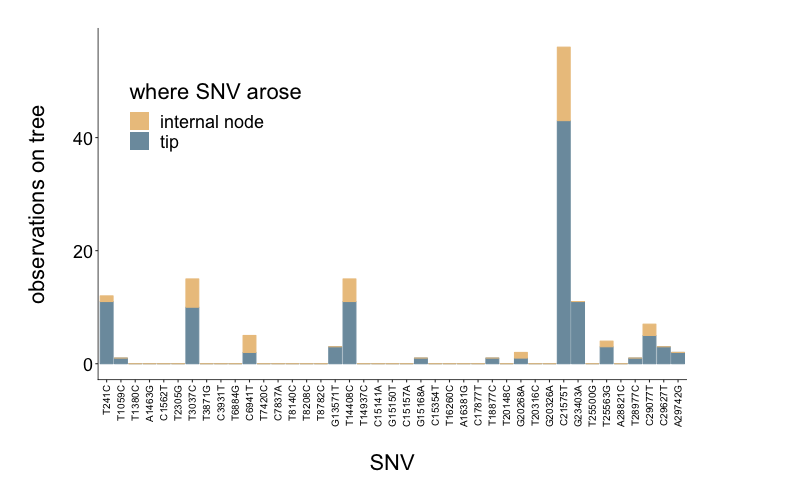

In [46]:
%%R -w 800 -h 500 -u px -i order_of_variants,times_detected_cutoff_to_plot,variant_percent,current_date,df_to_plot2,tip_color,node_color  # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

df_to_plot2 <- df_to_plot2[(df_to_plot2$within_host_counts>=times_detected_cutoff_to_plot),]
df_to_plot2$snv_f = factor(df_to_plot2$snv, levels=c(order_of_variants))

output_filename = paste("SNVs-on-global-tree-at-least-",times_detected_cutoff_to_plot,"times-detected-",variant_percent,"percent-",current_date,".pdf", sep="")

p <- ggplot(data=df_to_plot2, aes(x=snv_f, y=value, color=variable, fill=variable)) + 
    geom_col()+
    geom_text(data=df_to_plot2, aes(x=snv_f, y=total_tree_counts + 0.5, label=significance), color="black",size=15)+
    labs(x="\nSNV",y="observations on tree\n")+
    scale_color_manual(values=c(arose_on_tip=tip_color,arose_on_internal_node=node_color), guide=FALSE)+
    scale_fill_manual(values=c(arose_on_tip=tip_color,arose_on_internal_node=node_color), labels=c(arose_on_tip="tip", arose_on_internal_node="internal node"))+
    #scale_y_continuous(breaks=seq(0,70,10), limits=c(0,70))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=22, vjust=5))+
    theme(axis.text.y=element_text(size=18, colour="black"))+
    theme(axis.text.x=element_text(size=10, colour="black", angle=90, hjust=1,vjust=0.5))+
    theme(legend.text=element_text(size=18))+
    theme(legend.title=element_text(size=22))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    theme(legend.position = c(0.2, 0.75))+
    guides(fill=guide_legend(title="where SNV arose"))

ggsave(output_filename, width = 12, height = 10, device = "pdf", path = "../figures/", dpi = 300)
p

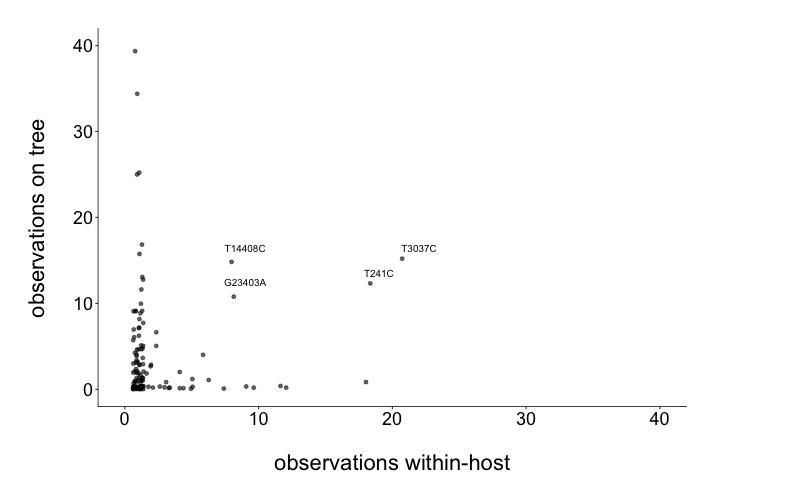

In [52]:
%%R -w 800 -h 500 -u px -i variant_percent,current_date,within_vs_tree  # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("SNVs-counts-on-global-tree-vs-wh-",variant_percent,"percent-",current_date,".pdf", sep="")

p <- ggplot(data=within_vs_tree, aes(x=within_host_counts, y=total_tree_counts)) + 
    geom_jitter(alpha=0.6)+
    labs(x="\nobservations within-host",y="observations on tree\n")+
    geom_text(aes(x=within_host_counts+1,y=total_tree_counts + 1.5,label=label), size=3.5)+
    scale_color_manual(values=c(arose_on_tip=tip_color,arose_on_internal_node=node_color), guide=FALSE)+
    scale_fill_manual(values=c(arose_on_tip=tip_color,arose_on_internal_node=node_color), labels=c("tip", "internal node"))+
    scale_y_continuous(breaks=seq(0,40,10), limits=c(0,40))+
    scale_x_continuous(breaks=seq(0,40,10), limits=c(0,40))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=22, vjust=5))+
    theme(axis.text.y=element_text(size=18, colour="black"))+
    theme(axis.text.x=element_text(size=18, colour="black"))+
    theme(legend.text=element_text(size=18))+
    theme(legend.title=element_text(size=22))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    theme(legend.position = c(1.0, 0.75))+
    guides(fill=guide_legend(title="where SNV arose"))

ggsave(output_filename, width = 7, height = 5, device = "pdf", path = "../figures/individual-pdfs/", dpi = 300)
p